In [1]:
import numpy as np
import rebound as rb
from celmech.secular import SecularSystemSimulation, LaplaceLagrangeSystem
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech.generating_functions import FirstOrderGeneratingFunction
import matplotlib.pyplot as plt
from celmech.nbody_simulation_utilities import align_simulation,set_timestep
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
from sympy import init_printing
init_printing()

This notebook demonstrates how to use the FirstOrderGeneratingFunction class to calculate approximate mean elements from a set of osculating elements taken from a `rebound` direct $N$-body simulation.

A generating function, $\chi(q',p')$, is a function of canconical elements that is used to generate a Lie transformation. The Lie transformation, $f\rightarrow f'$ of a function $f$ is defined as 
$$f'(q',p') = \exp[{\cal L}_\chi]f(q',p') = \sum_{n=0}^\infty \frac{1}{n!}{\cal L}_\chi^n f(q',p')$$
where ${\cal L}_\chi= [\cdot,\chi]$ is the Lie derivative with respect to $\chi$, i.e., the Poisson bracket of a function with $\chi$. 

Lie transformation provide canonical transformation of variables and, generally, the goal of applying a Lie transformation is to eliminate the dependence of a Hamiltonian on a set of variables up to a specific order in some small parameter. In other words, usually one seeks to transform a Hamiltonian of the form $H = H_0(p) + \epsilon H_1(q,p) + \epsilon^2H_2(q,p) + ...$, such that 
$$H'(q',p') = \exp[{\cal L}_\chi]H(q',p') = H'_0(p') + \epsilon^NH'_N(q',p')+....$$
This implies that $p' = \exp[{\cal L}_{\chi(q,p)}]p$ is a conserved quantity up to order $\epsilon^{N-1}$.

As a concrete example, let's consider the following simplified Hamiltonian that includes the leading-order secular disturbing function and terms from a 3:2 MMR:

$$
H = H_0 + \epsilon H_1\\
H_0 = -\frac{GM_*m_1}{2a_1} -\frac{GM_*m_2}{2a_2} \\
H_1 = -\frac{Gm_1m_2}{a_2}\left(\\
C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\cos(3\lambda_2-2\lambda_1-\varpi_1)+C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
+C_{(0,0,0,0,0,0)}^{(0,0,1,0)}e_1^2 + C_{(0,0,0,0,0,0)}^{(0,0,0,1)}e_2^2 + C_{(0,0,1,-1,0,0)}^{(0,0,0,0)}e_1e_2\cos(\varpi_1-\varpi_2)\\
\right)$$

Now we'll construct  for a generating function that elimnates the dependence on the mean longitudes to first order in the planet masses. If we assume that $\chi \sim \epsilon$, then we have  

$$
H' = \exp[{\cal L}_\chi]H =  H_0 + \epsilon H_1 + [H_0,\chi] +{\cal O}(\epsilon^2)
$$
In order for our canonical transformation to put our Hamiltonian in the desired form, eliminating dependence on the $\lambda_i$s at first order in $\epsilon$, we require

$$
H_1 + [H_0,\chi] = -\frac{Gm_1m_2}{a_2}\left(
C_{(0,0,0,0,0,0)}^{(0,0,1,0)}e_1^2 + C_{(0,0,0,0,0,0)}^{(0,0,0,1)}e_2^2 + C_{(0,0,1,-1,0,0)}^{(0,0,0,0)}e_1e_2\cos(\varpi_1-\varpi_2)\right)
$$

or, 
$$
n_1\frac{\partial\chi}{\partial\lambda_1} + n_2\frac{\partial\chi}{\partial\lambda_2} =  -\frac{Gm_1m_2}{a_2}\left(C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\cos(3\lambda_2-2\lambda_1-\varpi_1)+C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\cos(3\lambda_2-2\lambda_1-\varpi_2)\right)
$$

This equation is solved by choosing 
$$
\chi = -\frac{Gm_1m_2}{a_2}\left(\frac{C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\sin(3\lambda_2-2\lambda_1-\varpi_1)}{3n_2-2n_1}+\frac{C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\sin(3\lambda_2-2\lambda_1-\varpi_2)}{3n_2-2n_1}\right)
$$
and the transformed Hamiltonian is 

$$H' =  -\frac{GM_*m_1}{2a_1} -\frac{GM_*m_2}{2a_2} -\frac{Gm_1m_2}{a_2}\left(
C_{(0,0,0,0,0,0)}^{(0,0,1,0)}e_1^2 + C_{(0,0,0,0,0,0)}^{(0,0,0,1)}e_2^2 + C_{(0,0,1,-1,0,0)}^{(0,0,0,0)}e_1e_2\cos(\varpi_1-\varpi_2)\right) +$$

In [2]:
# This function will give us a pair of planets near a j:j-1 MMR 
def get_sim(m1,m2,j,Delta,z1,z2,inc):
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m=m1,P=1 ,e = np.abs(z1), pomega = np.angle(z1),Omega=0)
    sim.add(m=m2,P= j*( 1 + Delta)/(j-1),e = np.abs(z2), pomega = np.angle(z2), inc=inc, Omega=np.pi)
    align_simulation(sim)
    sim.move_to_com()
    return sim

In [3]:
Jres = 3
ecc = 0.0
sim = get_sim(3e-5,1e-4,Jres,0.01, 0.02 , 0.01 * np.exp(0.5j * np.pi), 0.04 )

Set up simple Hamiltonian model

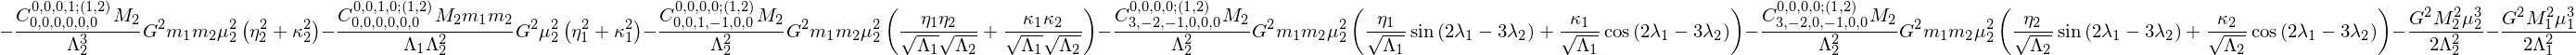

In [4]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)
pham.add_eccentricity_MMR_terms(Jres,1,1,update=False)
pham.add_monomial_term([0 for _ in range(6)],[0,0,1,0],update=False)
pham.add_monomial_term([0 for _ in range(6)],[0,0,0,1],update=False)
pham.add_monomial_term([0,0,1,-1,0,0],[0,0,0,0])
pham.H

Set up generating function

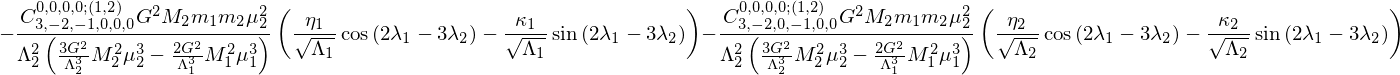

In [5]:
pvarsTr = pvars.copy()
chi = FirstOrderGeneratingFunction(pvarsTr)
chi.add_eccentricity_MMR_terms(Jres,1,1)
chi.H

# Integrate

In [6]:
Nout = 200
p1,p2 = sim.particles[1:]
Tsuper = np.abs(2 * np.pi / ((1-Jres) * p1.n + Jres * p2.n))

T = np.linspace(0,16*Tsuper,Nout)

# Arrays for osculating elements
a,e,pomega,l = np.zeros((4,2,Nout))

# Arrays for transformed, mean elements
aTr,eTr,pomegaTr,lTr = np.zeros((4,2,Nout))


for i,t in enumerate(T):
    pham.integrate(t)
    y = pham.state_to_list(pham.state)
    chi.update_state_from_list(chi.state, y)
    chi.osculating_to_mean()
    for j,p in enumerate(pham.particles[1:]):
        a[j,i] = p.a
        e[j,i] = p.e
        pomega[j,i] = p.pomega
        l[j,i] = p.l
        pTr = chi.particles[j+1]
        aTr[j,i] = pTr.a
        eTr[j,i] = pTr.e
        pomegaTr[j,i] = pTr.pomega
        lTr[j,i] = pTr.l

/Users/shadden/anaconda/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


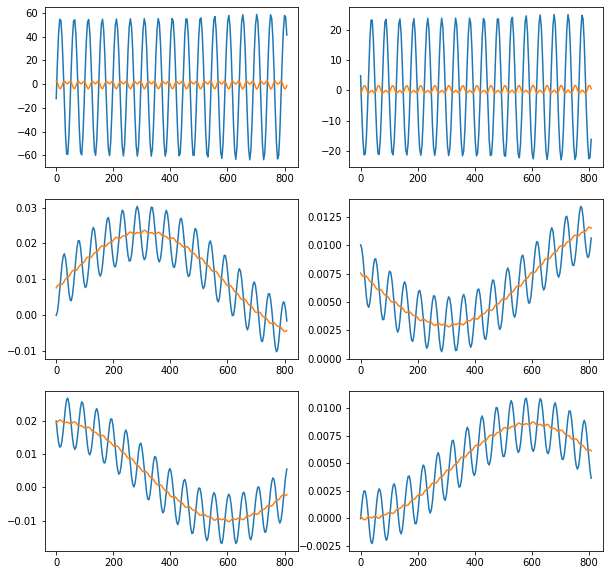

In [7]:
daBya = np.transpose((a.T-np.mean(a,axis=1))/np.mean(a,axis=1))
daByaTr = np.transpose((aTr.T-np.mean(aTr,axis=1))/np.mean(aTr,axis=1))
h,k = e * np.array([np.sin(pomega),np.cos(pomega)])
hTr,kTr = eTr * np.array([np.sin(pomegaTr),np.cos(pomegaTr)])
fig,ax = plt.subplots(3,2,figsize=(10,10))
for i in range(2):
    ax[0,i].plot(T,1e5 * daBya[i])
    ax[0,i].plot(T,1e5 * daByaTr[i])
    
    ax[1,i].plot(T,h[i])
    ax[1,i].plot(T,hTr[i])
    
    ax[2,i].plot(T,k[i])
    ax[2,i].plot(T,kTr[i])

# N-body case

In [8]:
from celmech.disturbing_function import ResonanceTermsList

In [9]:
for j in range(2*Jres):
    if j==Jres:
        # Add near-resonant terms up to 2nd order in e's and I's
        for k,z in ResonanceTermsList(Jres,1,2,2):
            chi.add_monomial_term(list(k),list(z),update=False)
    else:
        # add other first order in e terms
        chi.add_monomial_term([j,1-j,-1,0,0,0],[0,0,0,0],update=False)
        chi.add_monomial_term([j,1-j,0,-1,0,0],[0,0,0,0],update=False)
chi.add_zeroth_order_term()    

In [10]:
a = np.zeros((2,Nout))
e = np.zeros((2,Nout))
inc = np.zeros((2,Nout))
pomega = np.zeros((2,Nout))
Omega = np.zeros((2,Nout))
l = np.zeros((2,Nout))

states = []
for i,t in enumerate(T):
    sim.integrate(t)
    pvars = Poincare.from_Simulation(sim)
    states.append(chi.state_to_list(pvars))
    orbits = get_canonical_heliocentric_orbits(sim)
    for j,o in enumerate(orbits):
        a[j,i] = o.a
        e[j,i] = o.e
        pomega[j,i] = o.pomega
        l[j,i] = o.l
        inc[j,i] = o.inc
        Omega[j,i] = o.Omega

In [11]:
pvars = chi.state
a_mean = np.zeros((2,Nout))
e_mean = np.zeros((2,Nout))
pomega_mean = np.zeros((2,Nout))
inc_mean = np.zeros((2,Nout))
Omega_mean = np.zeros((2,Nout))
l_mean = np.zeros((2,Nout))
for i,state in enumerate(states):
    chi.update_state_from_list(pvars,state)
    chi.osculating_to_mean()
    for j,o in enumerate(pvars.particles[1:]):
        a_mean[j,i] = o.a
        e_mean[j,i] = o.e
        pomega_mean[j,i] = o.pomega
        l_mean[j,i] = o.l
        inc_mean[j,i] = o.inc
        Omega_mean[j,i] = o.Omega

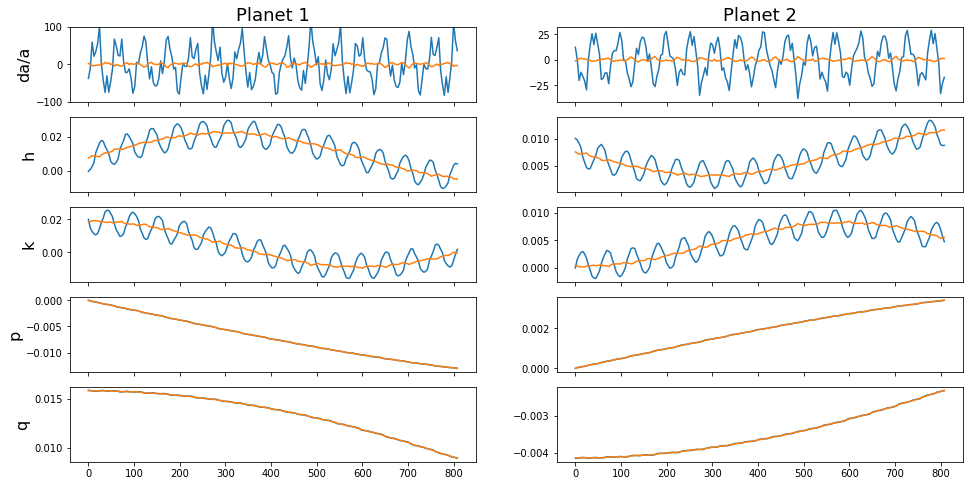

In [12]:
fig,ax = plt.subplots(5,2,sharex=True,figsize=(16,8))
h,k = e * np.sin(pomega),e * np.cos(pomega)
p,q = np.sin(inc/2) * np.sin(Omega),np.sin(inc/2) * np.cos(Omega)


h_mean,k_mean = e_mean * np.sin(pomega_mean),e_mean * np.cos(pomega_mean)
p_mean,q_mean = np.sin(inc_mean/2) * np.sin(Omega_mean),np.sin(inc_mean/2) * np.cos(Omega_mean)

for i in range(2):
    daBya = (a[i]-np.mean(a[i])) / np.mean(a[i])
    da_meanBya_mean = (a_mean[i]-np.mean(a_mean[i])) / np.mean(a_mean[i])
    ax[0,i].plot(T,1e5 * daBya)
    ax[0,i].plot(T,1e5 * da_meanBya_mean)

    ax[1,i].plot(T,h[i])
    ax[1,i].plot(T,h_mean[i])
    
    ax[2,i].plot(T,k[i])
    ax[2,i].plot(T,k_mean[i])


    ax[3,i].plot(T,p[i])
    ax[3,i].plot(T,p_mean[i])
    
    ax[4,i].plot(T,q[i])
    ax[4,i].plot(T,q_mean[i])
    
for i,lbl in  enumerate(['da/a','h','k','p','q']):
    ax[i,0].set_ylabel(lbl,fontsize=16)
    
ax[0,0].set_title("Planet 1",fontsize=18)
ax[0,1].set_title("Planet 2",fontsize=18)
ax[0,0].set_ylim(-100,100);